# Pima Indian Diabetes Prediction

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline

## Loading and Reviewing the Data

In [4]:
data_frame = pd.read_csv("/content/pimadataorig.csv")

In [5]:
data_frame.shape

(768, 9)

In [6]:
data_frame.head(5)

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
data_frame.tail(5)

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


## Check for null values

In [8]:
print (data_frame.isnull().values.any())

False


### Correlated Feature Check

Helper function that displays correlation by color.  Red is most correlated, Blue least.

In [9]:
def plot_corr(data_frame, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        data_frame: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = data_frame.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks


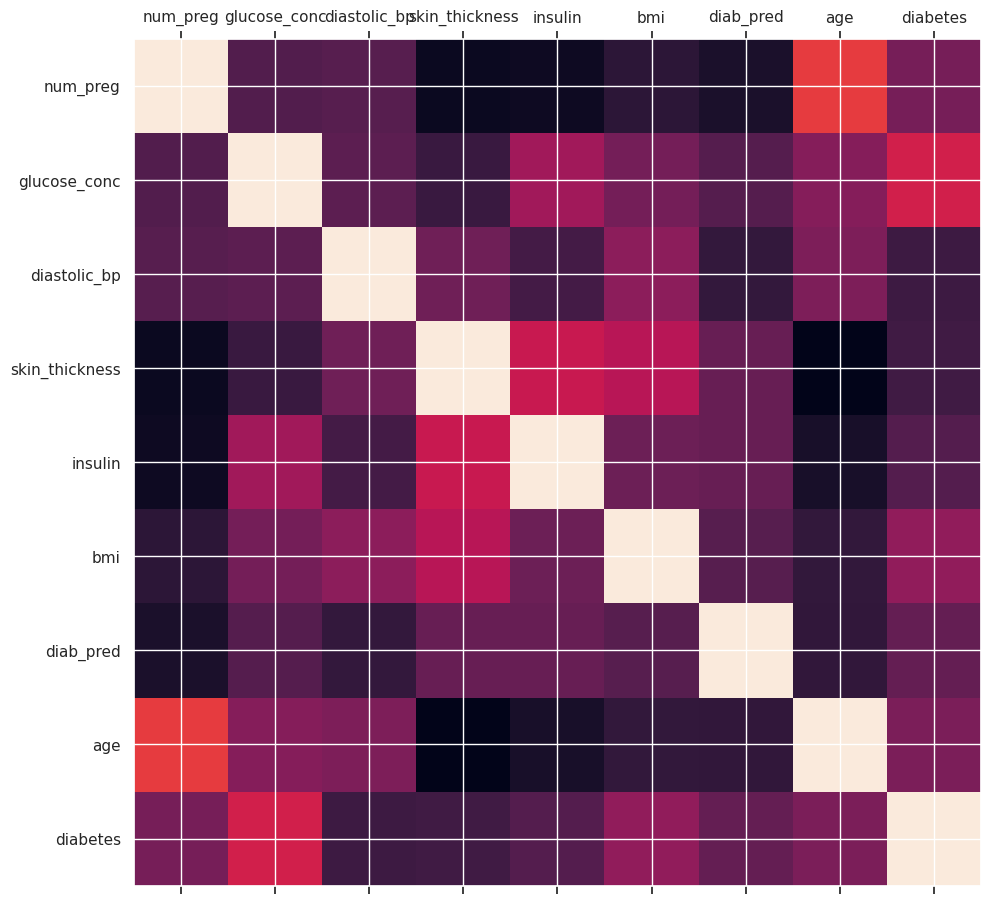

In [10]:
plot_corr(data_frame)

In [11]:
data_frame.corr()

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
num_preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose_conc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
diastolic_bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin_thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
diab_pred,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [12]:
data_frame.head(5)

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The skin and thickness columns are correlated 1 to 1.  Dropping the skin column

Check for additional correlations

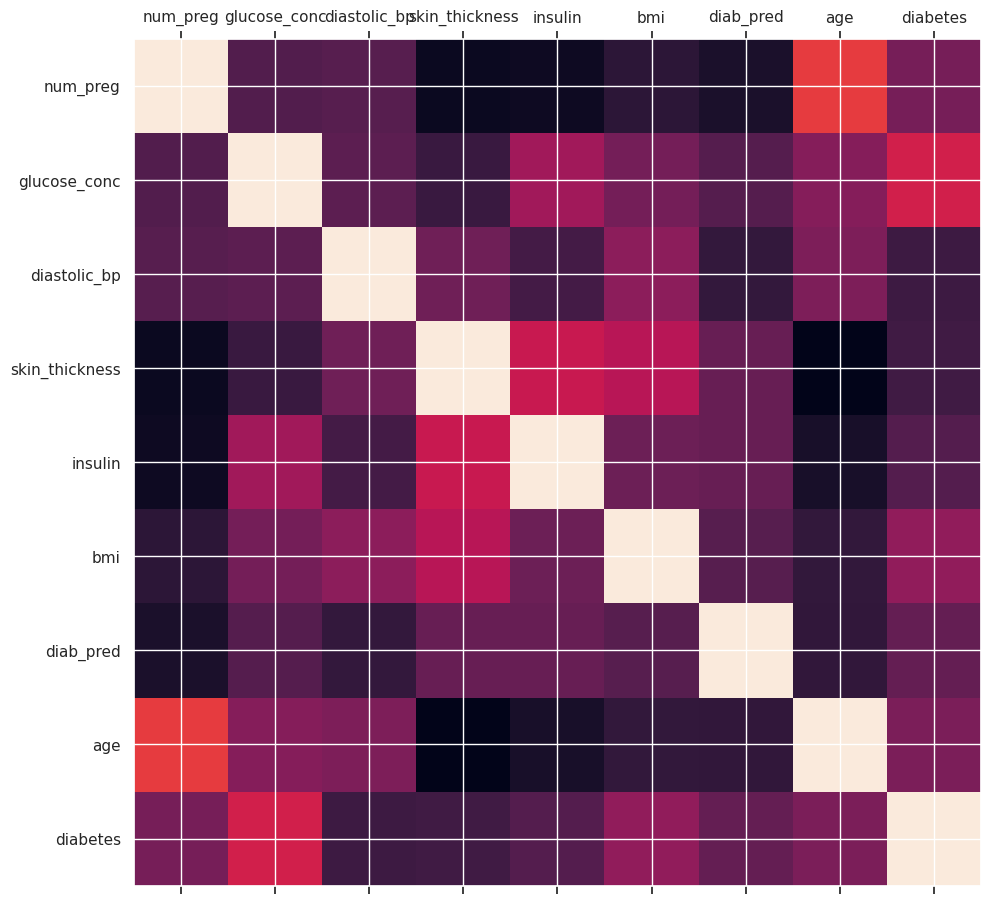

In [13]:
plot_corr(data_frame)

The correlations look good.  There appear to be no coorelated columns.

## Mold Data

### Data Types

Inspect data types to see if there are any issues.  Data should be numeric.

Verify that the diabetes data type has been changed.

In [14]:
data_frame.head(5)

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check for null values

In [15]:
data_frame.isnull().values.any()

False

No obvious null values.

### Check class distribution

Rare events are hard to predict

In [16]:
num_obs = len(data_frame)
num_true = len(data_frame.loc[data_frame['diabetes'] == 1])
num_false = len(data_frame.loc[data_frame['diabetes'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, ((1.00 * num_true)/(1.0 * num_obs)) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (( 1.0 * num_false)/(1.0 * num_obs)) * 100))

Number of True cases:  268 (34.90%)
Number of False cases: 500 (65.10%)


Good distribution of true and false cases.  No special work needed.

### Spliting the data

70% for training, 30% for testing

In [17]:
from sklearn.model_selection import train_test_split

feature_col_names = ['num_preg', 'glucose_conc', 'diastolic_bp', 'skin_thickness', 'insulin', 'bmi', 'diab_pred', 'age']
predicted_class_names = ['diabetes']

X = data_frame[feature_col_names].values     # predictor feature columns (8 X m)
y = data_frame[predicted_class_names].values # predicted class (1=true, 0=false) column (1 X m)
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)
                            # test_size = 0.3 is 30%, 42 is the answer to everything

We check to ensure we have the the desired 70% train, 30% test split of the data

In [18]:
trainval = (1.0 * len(X_train)) / (1.0 * len(data_frame.index))
testval = (1.0 * len(X_test)) / (1.0 * len(data_frame.index))
print("{0:0.2f}% in training set".format(trainval * 100))
print("{0:0.2f}% in test set".format(testval * 100))

69.92% in training set
30.08% in test set


#### Verifying predicted value was split correctly

In [19]:
print("Original True  : {0} ({1:0.2f}%)".format(len(data_frame.loc[data_frame['diabetes'] == 1]), (len(data_frame.loc[data_frame['diabetes'] == 1])/len(data_frame.index)) * 100.0))
print("Original False : {0} ({1:0.2f}%)".format(len(data_frame.loc[data_frame['diabetes'] == 0]), (len(data_frame.loc[data_frame['diabetes'] == 0])/len(data_frame.index)) * 100.0))
print("")
print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))


Original True  : 268 (34.90%)
Original False : 500 (65.10%)

Training True  : 188 (35.01%)
Training False : 349 (64.99%)

Test True      : 80 (34.63%)
Test False     : 151 (65.37%)


### Post-split Data Preparation

#### Hidden Missing Values

In [20]:
data_frame.head()

,num_preg,glucose_conc,diastolic_bp,skin_thickness,insulin,bmi,diab_pred,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Are these 0 values possible?

How many rows have have unexpected 0 values?

In [21]:
print("# rows in dataframe {0}".format(len(data_frame)))
print("# rows missing glucose_conc: {0}".format(len(data_frame.loc[data_frame['glucose_conc'] == 0])))
print("# rows missing diastolic_bp: {0}".format(len(data_frame.loc[data_frame['diastolic_bp'] == 0])))
print("# rows missing skin thickness: {0}".format(len(data_frame.loc[data_frame['skin_thickness'] == 0])))
print("# rows missing insulin: {0}".format(len(data_frame.loc[data_frame['insulin'] == 0])))
print("# rows missing bmi: {0}".format(len(data_frame.loc[data_frame['bmi'] == 0])))
print("# rows missing diab_pred: {0}".format(len(data_frame.loc[data_frame['diab_pred'] == 0])))
print("# rows missing age: {0}".format(len(data_frame.loc[data_frame['age'] == 0])))

# rows in dataframe 768
# rows missing glucose_conc: 5
# rows missing diastolic_bp: 35
# rows missing skin thickness: 227
# rows missing insulin: 374
# rows missing bmi: 11
# rows missing diab_pred: 0
# rows missing age: 0


#### Impute with the mean

In [22]:
from sklearn.impute import SimpleImputer

#Impute with mean all 0 readings
fill_0 = SimpleImputer(missing_values=0, strategy="mean")

X_train = fill_0.fit_transform(X_train)
X_test = fill_0.fit_transform(X_test)

## Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object and train it with the data
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nb_model = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

nb_model.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.848035...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=1)

In [46]:
print(nb_model.best_estimator_)

GaussianNB(var_smoothing=0.0012328467394420659)


In [24]:
# this returns array of predicted results
prediction_from_trained_data = nb_model.predict(X_train)

In [25]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_train, prediction_from_trained_data)

print ("Accuracy of our naive bayes model is : {0:.4f}".format(accuracy))

Accuracy of our naive bayes model is : 0.7542


In [26]:
# this returns array of predicted results from test_data
prediction_from_test_data = nb_model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, prediction_from_test_data)

print ("Accuracy of our naive bayes model is: {0:0.4f}".format(accuracy))

Accuracy of our naive bayes model is: 0.7359


In [58]:
print ("Confusion Matrix for Naive Bayes")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.confusion_matrix(y_test, prediction_from_test_data, labels=[1, 0])))
print ("Classification Report")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.classification_report(y_test, prediction_from_test_data, labels=[1, 0])))

Confusion Matrix for Naive Bayes
[[ 52  28]
 [ 33 118]]
Classification Report
              precision    recall  f1-score   support

           1       0.61      0.65      0.63        80
           0       0.81      0.78      0.79       151

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42),param_grid=param_grid)
rf_model.fit(X_train, y_train.ravel())

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]})

In [30]:
print(rf_model.best_estimator_)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=25, random_state=42)


In [31]:
rf_predict_train = rf_model.predict(X_train)

#get accuracy
rf_accuracy = metrics.accuracy_score(y_train, rf_predict_train)

#print accuracy
print ("Accuracy: {0:.4f}".format(rf_accuracy))

Accuracy: 0.8473


In [32]:
rf_predict_test = rf_model.predict(X_test)

#get accuracy
rf_accuracy_testdata = metrics.accuracy_score(y_test, rf_predict_test)

#print accuracy
print ("Accuracy: {0:.4f}".format(rf_accuracy_testdata))

Accuracy: 0.7749


In [33]:
print ("Confusion Matrix for Random Forest")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.confusion_matrix(y_test, rf_predict_test, labels=[1, 0])))

print ("")

print ("Classification Report\n")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.classification_report(y_test, rf_predict_test, labels=[1, 0])))

Confusion Matrix for Random Forest
[[ 51  29]
 [ 23 128]]

Classification Report

              precision    recall  f1-score   support

           1       0.69      0.64      0.66        80
           0       0.82      0.85      0.83       151

    accuracy                           0.77       231
   macro avg       0.75      0.74      0.75       231
weighted avg       0.77      0.77      0.77       231



#Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

# create Gaussian Naive Bayes model object and train it with the data

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
dt_model = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dist, cv = 5)
dt_model.fit(X_train, y_train.ravel())

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b0f227a1d50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b0f227a2920>})

In [39]:
print("Tuned Decision Tree Parameters: {}".format(dt_model.best_params_))
print("Best score is {}".format(dt_model.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 4}
Best score is 0.7448944271374177


In [40]:
# this returns array of predicted results
prediction_from_trained_data = dt_model.predict(X_train)

In [41]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_train, prediction_from_trained_data)

print ("Accuracy of our DT model is : {0:.4f}".format(accuracy))

Accuracy of our DT model is : 0.7635


In [42]:
dt_predict_test = dt_model.predict(X_test)

#get accuracy
dt_accuracy_testdata = metrics.accuracy_score(y_test, dt_predict_test)

#print accuracy
print ("Accuracy: {0:.4f}".format(dt_accuracy_testdata))

Accuracy: 0.7186


In [43]:
print ("Confusion Matrix for DT")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.confusion_matrix(y_test, dt_predict_test, labels=[1, 0])))

print ("")

print ("Classification Report\n")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.classification_report(y_test, dt_predict_test, labels=[ 1,0])))


Confusion Matrix for DT
[[ 25  55]
 [ 10 141]]

Classification Report

              precision    recall  f1-score   support

           1       0.71      0.31      0.43        80
           0       0.72      0.93      0.81       151

    accuracy                           0.72       231
   macro avg       0.72      0.62      0.62       231
weighted avg       0.72      0.72      0.68       231



# **Results**

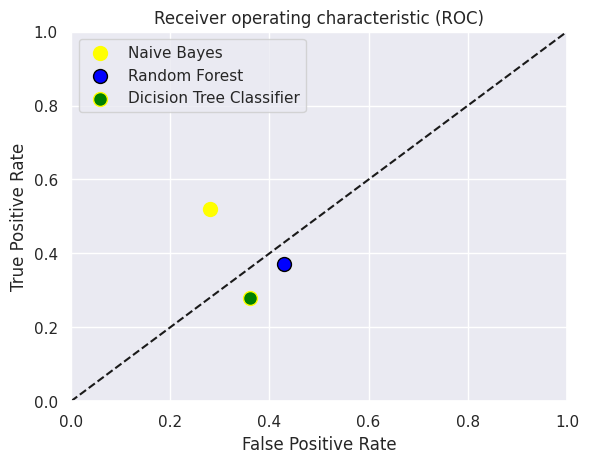

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# fpr, tpr
naive_bayes = np.array([0.28, 0.52])
logistic = np.array([0.54, 0.26])
random_forest = np.array([0.43, 0.37])
ann = np.array([0.36, 0.44])
svm = np.array([0.46, 0.34])
dt = np.array([0.52, 0.28])

#plotting
plt.scatter(naive_bayes[0], naive_bayes[1], label = 'Naive Bayes', facecolors='yellow', edgecolors='yellow', s=100)
plt.scatter(random_forest[0], random_forest[1], label = 'Random Forest', facecolors='blue', edgecolors='black', s=100)
plt.scatter(ann[0], dt[1], label = 'Dicision Tree Classifier', facecolors='green', edgecolors='yellow', s=100)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc='upper left')

plt.show()